# Optimized Outcomes


This section of the notebook calculates the optimal outcome for ecosystem services produced by fallowed land to meet SGMA targets by ranking parcels within each crop type by a weighted average ecosystem services metric and selecting the top ranked parcels by crop type to meet fallowing targets set by the [PPIC.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/) 

Weights may be adjusted before running the notebook. By default, all ecosystem services are equally weighted.

In [1]:
# User-specified inputs (region codes = ['KR', 'SE', 'SW'])
region_code = 'SW'

# Path to output, use as input to future notebooks
out_name = f'../outputs/optimal_{region_code}.csv'

# Specify if to save outputs, False if testing
save = True

In [2]:
import pandas as pd
import numpy as np
import geopandas as gd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

In [3]:
# Inputs
fields = gd.read_file('../outputs/fields_shape.shp')
trials = pd.read_csv(f'../outputs/trials_{region_code}.csv')
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')

In [4]:
df = fields[fields['PPIC_Regio']==region_code].dropna(axis=0)
df.head()

,Crop2014,Acres,FID,County,PPIC_Regio,Crop_PPIC,Price,Rotations,AdjustedPr,FieldCropP,...,Kitfox_Nor,Corridors_,CPAD_Norm,SavedWat_2,TNC_Total,Krat_Total,Kitfox_Tot,Corridor_1,CPAD_Total,geometry
53680,Almonds,82.362716,9,Fresno,SW,trees-vines,5995.531797,1.000000,5995.531797,493808.28,...,0.0,0.375959,0.0,56.556149,0.000000,0.000000,0.0,30.965004,0.0,POLYGON Z ((-13387997.89282141 4386519.7333870...
53681,Grapes,15.437437,10,Fresno,SW,trees-vines,15833.672780,1.000000,15833.672780,244431.33,...,0.0,0.000000,0.0,7.358578,0.000000,0.000000,0.0,0.000000,0.0,POLYGON Z ((-13318579.8538442 4362024.29720400...
53682,Walnuts,2.177882,12,Fresno,SW,trees-vines,3097.177570,1.000000,3097.177570,6745.29,...,0.0,0.000000,0.0,1.612492,0.000000,0.000000,0.0,0.000000,0.0,POLYGON Z ((-13334999.58825955 4358515.0676377...
53683,Cotton,102.611917,13,Fresno,SW,field-crops-grains,2089.492399,1.257426,2627.381531,269600.66,...,0.0,0.000000,0.0,57.948313,0.000000,0.000000,0.0,0.000000,0.0,POLYGON Z ((-13377618.42240505 4364424.0386532...
53685,Almonds,35.074071,26,Fresno,SW,trees-vines,5995.531797,1.000000,5995.531797,210287.71,...,0.0,0.978126,0.0,24.084036,34.314461,1.119575,0.0,34.306859,0.0,POLYGON Z ((-13376724.98126235 4411320.2972050...


In [5]:
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


In [6]:
df.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD',
       'SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_',
       'CPAD_Norm', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot',
       'Corridor_1', 'CPAD_Total', 'geometry'],
      dtype='object')

In [7]:
eco_services = ['SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_', 'CPAD_Norm']
crop_types = targets.columns

In [8]:
df[eco_services].max()

SavedWat_1    0.990501
TNC_Norm      1.000000
Krat_Norm     0.991077
Kitfox_Nor    0.994451
Corridors_    0.998668
CPAD_Norm     1.000000
dtype: float64

In [9]:
# # Create weights table with equal weights
# weight_vals = [1/len(eco_services)] * len(eco_services)
# out = OrderedDict(list(zip(eco_services, weight_vals)))
# out_df = pd.DataFrame(weight_vals, index = eco_services, columns = ['weights'])
# out_df.to_csv('../data/weights.csv')

In [10]:
weight_table = pd.read_csv('../data/weights.csv', index_col=0)
weight_table

,weights
SavedWat_1,0.166667
TNC_Norm,0.166667
Krat_Norm,0.166667
Kitfox_Nor,0.166667
Corridors_,0.166667
CPAD_Norm,0.166667


In [11]:
weights = np.array(weight_table['weights'])
weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [12]:
weights.shape[0] == df[eco_services].shape[1]

True

In [13]:
weight_table.index.values == df[eco_services].columns.values

array([ True,  True,  True,  True,  True,  True])

In [14]:
df['outcome'] = np.average(df[eco_services], weights=weights, axis=1)
df['outcome'].isna().sum()

0

In [15]:
df['outcome'].max()

0.7807338721648144

In [16]:
pd.set_option('display.max_columns', None)
df.loc[df['outcome'].sort_values().tail(10).index]

,Crop2014,Acres,FID,County,PPIC_Regio,Crop_PPIC,Price,Rotations,AdjustedPr,FieldCropP,WaterConsu,SavedWater,TNC,Krat,Kitfox,Corridors,CPAD,SavedWat_1,TNC_Norm,Krat_Norm,Kitfox_Nor,Corridors_,CPAD_Norm,SavedWat_2,TNC_Total,Krat_Total,Kitfox_Tot,Corridor_1,CPAD_Total,geometry,outcome
67730,Pistachios,94.661262,3453,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,675230.11,3.88441,367.70,93.174852,61.495403,73.608133,0.0,93.174852,0.757379,0.983614,0.847237,0.851661,0.0,0.983058,71.694464,93.110158,80.200495,80.619322,0.0,93.057464,POLYGON Z ((-13311826.05267952 4274247.9462627...,0.737158
69900,Pistachios,16.388707,6014,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,116902.61,3.88441,63.66,15.752531,11.341822,13.232126,0.0,15.752531,0.757380,0.960515,0.902553,0.884297,0.0,0.959971,12.412482,15.741594,14.791671,14.492489,0.0,15.732685,POLYGON Z ((-13308382.15256875 4277465.8371686...,0.744119
70069,Pistachios,39.115314,6219,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,279014.21,3.88441,151.94,29.845520,29.652968,35.429520,0.0,38.510348,0.757386,0.762484,0.988680,0.992046,0.0,0.983293,29.625392,29.824797,38.672529,38.804189,0.0,38.461830,POLYGON Z ((-13307861.99800163 4276005.1417663...,0.747315
69926,Pistachios,36.587135,6044,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,260980.41,3.88441,142.12,35.619477,26.536511,31.879432,0.0,35.619477,0.757389,0.972876,0.945910,0.954323,0.0,0.972325,27.710680,35.594746,34.608137,34.915954,0.0,35.574601,POLYGON Z ((-13311349.48750545 4274729.1901817...,0.767137
69069,Pistachios,33.960284,5043,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,242242.77,3.88441,131.92,33.422665,24.621363,28.966310,0.0,33.422665,0.757411,0.983486,0.945530,0.934190,0.0,0.982929,25.721876,33.399458,32.110458,31.725356,0.0,33.380557,POLYGON Z ((-13308382.75612794 4276980.9829606...,0.767258
67465,Pistachios,16.166540,3130,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,115317.86,3.88441,62.80,15.510787,11.943306,14.269924,0.0,15.510787,0.757416,0.958771,0.963478,0.966758,0.0,0.958229,12.244798,15.500017,15.576108,15.629137,0.0,15.491245,POLYGON Z ((-13308368.79032771 4276495.2411918...,0.767442
67622,Pistachios,17.373977,3322,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,123930.66,3.88441,67.49,16.683532,12.846320,15.348850,0.0,16.683532,0.757412,0.959593,0.964304,0.967587,0.0,0.959050,13.159259,16.671948,16.753792,16.810831,0.0,16.662513,POLYGON Z ((-13308380.97499297 4276734.7584733...,0.767991
66027,Pistachios,18.356865,1390,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,130941.71,3.88441,71.31,17.945848,13.818303,16.510180,0.0,17.945848,0.757432,0.976931,0.981727,0.985069,0.0,0.976378,13.904085,17.933387,18.021424,18.082778,0.0,17.923238,POLYGON Z ((-13307866.62613507 4276496.2914770...,0.779589
70278,Pistachios,35.225399,6478,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,251266.99,3.88441,136.83,34.474298,26.545209,31.716354,0.0,34.474298,0.757386,0.977998,0.982799,0.986145,0.0,0.977444,26.679232,34.450361,34.619481,34.737343,0.0,34.430865,POLYGON Z ((-13308365.99646563 4276485.7150078...,0.780295
66686,Pistachios,15.340604,2177,Kings,SW,trees-vines,7133.119636,1.0,7133.119636,109426.36,3.88441,59.59,15.023531,11.568119,13.821648,0.0,15.023531,0.757396,0.978651,0.983455,0.986804,0.0,0.978097,11.618910,15.013100,15.086800,15.138163,0.0,15.004603,POLYGON Z ((-13307891.48291306 4275789.3753304...,0.780734


In [17]:
df.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD',
       'SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_',
       'CPAD_Norm', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot',
       'Corridor_1', 'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

In [18]:
#Get list of columns to track for each repetition
outcome_cols = ['Acres', 'FieldCropP', 'SavedWat_1', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
                'CPAD_Total', 'outcome'] 

In [19]:
df_optimal = pd.DataFrame(columns=df.columns)
for crop in crop_types:
    df_crop = df[df['Crop_PPIC'] == crop]
    target = targets.loc[region_code, crop]
    df_crop_sorted = df_crop.sort_values(['AdjustedPr','outcome'], ascending=[True,False])
    # Identify fields up to target
    df_fallow_bool = df_crop_sorted['Acres'].cumsum() < target
    # Get one additional field by updating value from False to True where 
    # first instance of False is located
    if not df_fallow_bool[df_fallow_bool!=True].empty:
        index = df_fallow_bool[df_fallow_bool!=True].index[0]
        df_fallow_bool.at[index]=True        
    df_crop_fallow = df_crop_sorted[df_fallow_bool]
    df_optimal = df_optimal.append(df_crop_fallow, ignore_index=True)
outcomes = pd.DataFrame(df_optimal[outcome_cols].sum()).T
areas = df_optimal[['Acres','Crop_PPIC']].groupby('Crop_PPIC').sum().T
areas.reset_index(drop=True, inplace=True)
output = pd.concat([outcomes, areas], axis=1, sort=False)

In [20]:
df_optimal.head(10)

,Crop2014,Acres,FID,County,PPIC_Regio,Crop_PPIC,Price,Rotations,AdjustedPr,FieldCropP,WaterConsu,SavedWater,TNC,Krat,Kitfox,Corridors,CPAD,SavedWat_1,TNC_Norm,Krat_Norm,Kitfox_Nor,Corridors_,CPAD_Norm,SavedWat_2,TNC_Total,Krat_Total,Kitfox_Tot,Corridor_1,CPAD_Total,geometry,outcome
0,Mixed Pasture,34.353959,19120,Fresno,SW,alfalfa-pasture,15.917905,1.181818,18.812069,646.27,4.706311,161.68,33.568925,1.007068,15.106016,33.568925,33.568925,0.917638,0.976470,0.038231,0.481600,0.976254,0.975918,31.524506,33.545617,1.313388,16.544867,33.538185,33.526632,POLYGON Z ((-13396064.15272469 4402192.9412711...,0.727685
1,Mixed Pasture,1.494736,32681,Fresno,SW,alfalfa-pasture,15.917905,1.181818,18.812069,28.12,4.706311,7.03,1.449961,0.449488,0.753980,0.000000,1.449961,0.917029,0.969372,0.392182,0.552470,0.000000,0.968823,1.370715,1.448955,0.586209,0.825797,0.000000,1.448134,POLYGON Z ((-13392731.30409614 4401993.9391072...,0.633313
2,Mixed Pasture,16.978484,8759,Fresno,SW,alfalfa-pasture,15.917905,1.181818,18.812069,319.40,4.706311,79.91,16.138444,2.824228,8.149914,0.000000,16.138444,0.917686,0.949863,0.216938,0.525736,0.000000,0.949326,15.580921,16.127238,3.683275,8.926195,0.000000,16.118111,POLYGON Z ((-13392571.32735164 4401391.3118646...,0.593258
3,Mixed Pasture,14.124173,5526,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,265.70,4.699086,66.37,0.000000,0.000000,7.175705,13.412533,13.412533,0.916222,0.000000,0.000000,0.556436,0.948746,0.948419,12.940880,0.000000,0.000000,7.859192,13.400251,13.395635,POLYGON Z ((-13345447.84714422 4353071.4601879...,0.561637
4,Mixed Pasture,22.319226,4289,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,419.87,4.699086,104.88,0.000000,0.000000,11.074274,21.296681,21.296681,0.916232,0.000000,0.000000,0.543437,0.953312,0.952983,20.449593,0.000000,0.000000,12.129101,21.277180,21.269850,POLYGON Z ((-13345790.07263336 4353243.8596799...,0.560994
5,Mixed Pasture,6.106103,7660,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,114.87,4.699086,28.69,0.000000,0.000000,2.508538,5.701223,5.701223,0.916133,0.000000,0.000000,0.449956,0.932838,0.932516,5.594001,0.000000,0.000000,2.747477,5.696002,5.694040,POLYGON Z ((-13345722.26331561 4352584.5456518...,0.538574
6,Mixed Pasture,9.932567,8198,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,186.85,4.699086,46.67,0.000000,0.000000,2.726800,9.402760,9.402760,0.916154,0.000000,0.000000,0.300680,0.945793,0.945467,9.099757,0.000000,0.000000,2.986529,9.394149,9.390913,POLYGON Z ((-13345552.73970786 4352579.2817373...,0.518016
7,Mixed Pasture,37.451252,5861,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,704.54,4.699086,175.99,0.000000,0.000000,16.300580,36.223512,11.229289,0.916249,0.000000,0.000000,0.476705,0.966332,0.299460,34.314682,0.000000,0.000000,17.853214,36.190342,11.215141,POLYGON Z ((-13345142.70483536 4353039.8760292...,0.443124
8,Mixed Pasture,2.123847,4052,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,39.95,4.699086,9.98,0.000000,0.000000,0.263052,1.644078,1.644078,0.916219,0.000000,0.000000,0.135654,0.773395,0.773129,1.945909,0.000000,0.000000,0.288108,1.642572,1.642006,POLYGON Z ((-13346122.21908504 4349115.1414008...,0.433066
9,Mixed Pasture,64.964635,2834,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,1222.12,4.699086,305.27,63.486561,0.000000,5.396358,39.679101,0.000000,0.916219,0.976569,0.000000,0.090978,0.610221,0.000000,59.521808,63.442480,0.000000,5.910362,39.642766,0.000000,POLYGON Z ((-13318888.56833607 4285605.4981736...,0.432331


In [21]:
if save:
    df_optimal.to_csv(out_name)
df_optimal.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD',
       'SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_',
       'CPAD_Norm', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot',
       'Corridor_1', 'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


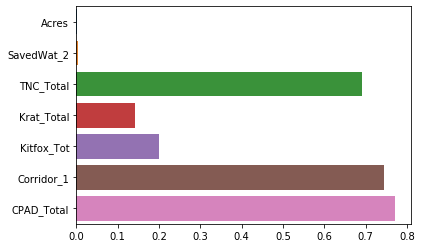

In [22]:
plot_cols = ['Acres', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridor_1',
            'CPAD_Total']  #Exclude FieldCropPrice and optimal
optimal = df_optimal[plot_cols].sum()
as_usual = trials[plot_cols].mean()
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = df_optimal[plot_cols].columns)

In [23]:
optimal_cost = df_optimal['FieldCropP'].sum()
print(f'${optimal_cost.sum():,.2f}')

$216,171,700.90


In [24]:
average_cost = trials['FieldCropP'].mean()
print(f'${average_cost:,.2f}')

$215,723,459.65


In [25]:
cost = df_optimal['FieldCropP'].sum() - trials['FieldCropP'].mean()
print (f'The cost of this optimization is ${cost:,.0f}')

The cost of this optimization is $448,241


In [26]:
for crop in crop_types:
    area_diff = df_optimal[df_optimal['Crop_PPIC']==crop]['Acres'].sum() - trials[crop].mean()
    print (f'{area_diff:,.2f} acres of {crop}')

-35.41 acres of alfalfa-pasture
-3.50 acres of corn
76.96 acres of field-crops-grains
26.58 acres of veg-fruits
44.75 acres of trees-vines


In [27]:
df.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD',
       'SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_',
       'CPAD_Norm', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot',
       'Corridor_1', 'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

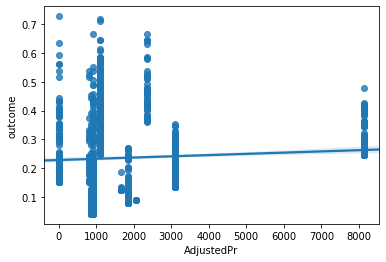

In [28]:
sns.regplot(y=df_optimal['outcome'], x=df_optimal['AdjustedPr'])

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


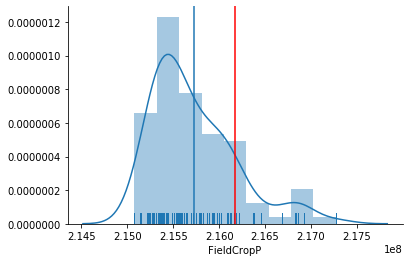

In [29]:
sns.distplot(trials['FieldCropP'], rug=True)
plt.axvline(x = df_optimal['FieldCropP'].sum(), color='red')
plt.axvline(x = trials['FieldCropP'].mean())
sns.despine()

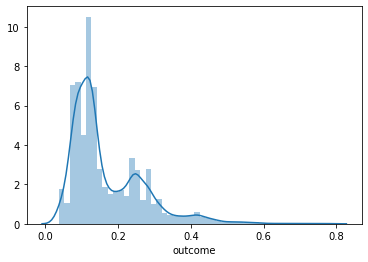

In [30]:
sns.distplot(df.dropna(subset=['outcome'])['outcome'])

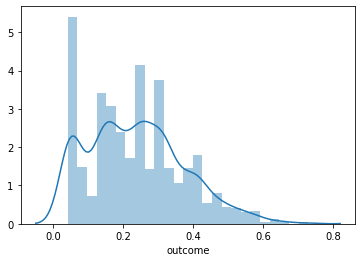

In [31]:
sns.distplot(df_optimal.dropna(subset=['outcome'])['outcome'])

In [32]:
sub_crops = df['Crop2014'].unique()
sub_crops

array(['Almonds', 'Grapes', 'Walnuts', 'Cotton', 'Pistachios',
       'Pomegranates', 'Tomatoes', 'Corn, Sorghum and Sudan',
       'Alfalfa and Alfalfa Mixtures', 'Melons, Squash and Cucumbers',
       'Miscellaneous Grasses', 'Peaches/Nectarines',
       'Miscellaneous Grain and Hay', 'Carrots',
       'Plums, Prunes and Apricots', 'Cherries',
       'Miscellaneous Truck Crops', 'Onions and Garlic',
       'Young Perennials', 'Lettuce/Leafy Greens', 'Citrus', 'Wheat',
       'Pears', 'Cole Crops', 'Mixed Pasture', 'Miscellaneous Deciduous',
       'Bush Berries', 'Olives', 'Apples', 'Peppers', 'Safflower',
       'Kiwis', 'Flowers, Nursery and Christmas Tree Farms',
       'Beans (Dry)', 'Strawberries', 'Miscellaneous Subtropical Fruits'],
      dtype=object)

In [33]:
len(sub_crops)

36

In [34]:
data = df_optimal[df_optimal['Crop2014']=='Alfalfa and Alfalfa Mixtures']
x = data['FieldCropP']
y = data['outcome']

In [35]:
df_by_crop = df_optimal.groupby(['Crop2014']).mean()
df_by_crop

,Acres,Price,Rotations,AdjustedPr,FieldCropP,WaterConsu,SavedWater,TNC,Krat,Kitfox,Corridors,CPAD,SavedWat_1,TNC_Norm,Krat_Norm,Kitfox_Nor,Corridors_,CPAD_Norm,SavedWat_2,TNC_Total,Krat_Total,Kitfox_Tot,Corridor_1,CPAD_Total,outcome
Crop2014,,,,,,,,,,,,,,,,,,,,,,,,,
Alfalfa and Alfalfa Mixtures,56.120807,1113.653444,1.000000,1113.653444,62499.129933,4.753100,265.882881,3.469528,0.181800,12.901200,18.186054,32.868549,0.926764,0.094819,0.004950,0.261794,0.302707,0.541313,51.842074,3.467119,0.237098,14.130042,18.169400,32.827139,0.355391
Apples,29.913272,1657.747573,1.000000,1657.747573,49588.654667,3.833797,114.386667,0.000000,0.000000,0.464274,0.000000,0.000000,0.747516,0.000000,0.000000,0.031076,0.000000,0.000000,22.303211,0.000000,0.000000,0.508496,0.000000,0.000000,0.129765
Beans (Dry),171.963417,1060.225352,1.935484,2052.049069,352877.370000,2.784316,478.802000,0.000000,0.000000,0.000000,0.000000,0.000000,0.542889,0.000000,0.000000,0.000000,0.000000,0.000000,93.357228,0.000000,0.000000,0.000000,0.000000,0.000000,0.090482
"Corn, Sorghum and Sudan",57.644699,1061.698113,2.222222,2359.329140,136002.817206,2.827557,161.245441,11.443216,0.923075,7.093819,52.256375,55.079131,0.551319,0.182501,0.024947,0.140463,0.899642,0.949101,31.439775,11.435271,1.203847,7.769507,52.208523,55.009739,0.457995
Miscellaneous Grain and Hay,85.856051,493.250000,1.740741,858.620370,73717.754679,1.395178,119.160550,3.262190,1.270148,5.949594,7.702946,18.695788,0.272039,0.041319,0.024819,0.103593,0.088020,0.204534,23.234027,3.259925,1.656490,6.516294,7.695892,18.672234,0.122388
Miscellaneous Grasses,36.387433,347.114537,2.352941,816.740088,29719.075946,4.700062,170.995676,1.109692,0.067520,4.333787,4.675231,6.145652,0.916449,0.037158,0.018277,0.197463,0.129990,0.158540,33.340885,1.108922,0.088058,4.746581,4.670950,6.137910,0.242979
Mixed Pasture,9.848431,15.917905,1.181818,18.812069,185.269257,4.700874,46.298366,1.056298,0.037378,1.846198,1.588529,1.589364,0.916597,0.095417,0.009244,0.251474,0.078518,0.103110,9.027295,1.055564,0.048747,2.022049,1.587074,1.587362,0.242393
Safflower,214.553563,1061.698113,1.729730,1836.450790,394017.059432,2.376280,511.472500,0.098116,0.000000,10.417605,57.714281,3.423167,0.463333,0.000784,0.000000,0.046274,0.267945,0.038681,99.727350,0.098047,0.000000,11.409883,57.661431,3.418854,0.136169
Tomatoes,63.418362,4232.650066,1.920354,8128.186409,515476.269646,2.466959,157.886814,13.257713,0.420411,1.814409,39.463781,25.709961,0.481010,0.202589,0.018859,0.044102,0.658038,0.351527,30.784907,13.248508,0.548288,1.987232,39.427643,25.677570,0.292688


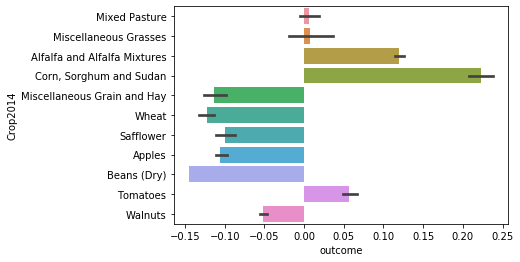

In [36]:
crop_mean_outcome = df_optimal['outcome'].mean()
sns.barplot(data=df_optimal, x='outcome', y='Crop2014', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

# Mapping

In [37]:
fields_to_map = fields[fields['PPIC_Regio']==region_code].set_index('FID').join(df_optimal.set_index('FID'), how='inner', lsuffix = 'l')
# Alternative from geopandas (have to create new (or could rename) 'FID_1' to 'FID' to have matching column) 
#fields['FID'] = fields['FID_1']
#fields_to_map = fields.merge(df_optimal, on='FID')

In [38]:
plt.rcParams["figure.figsize"] = (20,10)
xlim = ([fields_to_map.geometry.total_bounds[0], fields_to_map.geometry.total_bounds[2]])
ylim = ([fields_to_map.geometry.total_bounds[1], fields_to_map.geometry.total_bounds[3]])

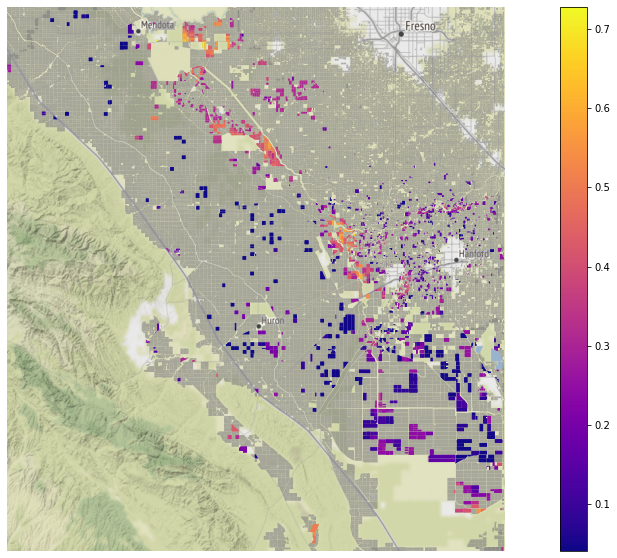

In [39]:
base = fields.plot(color='grey', alpha=0.6)
fields_to_map.plot(ax=base, column='outcome', cmap='plasma', legend=True)
base.set_xlim(xlim)
base.set_ylim(ylim)
ctx.add_basemap(base, url=ctx.sources.ST_TERRAIN, reset_extent=True)
base.set_axis_off()